In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize

In [2]:
### Calling NR waveforms (SAS simulations used)

(array([  602,   603,   604, ..., 14850, 14851, 14852]),)
14251
time: 3564.772879657674 
 index: 12759 
 length: 14251


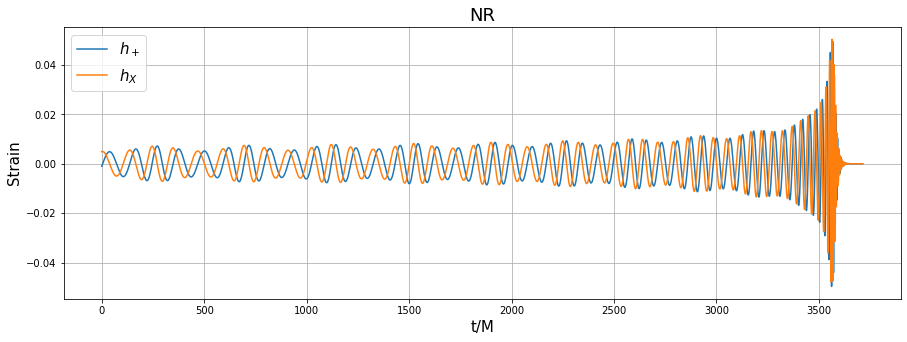

In [2]:
#modify filename to include directory path to file, 
#for e.g. '/home/SXSfiles/1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5' 
simulation = '1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5'  
tref = 340.0 #tref is the start time of usable SXS waveforms, check metadata of simulation to obtain it
sims = simulation.split('_')[0]
lp = 3  # change accordingly
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:     
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

print('time:',x1[np.argmax(amp)],'\n index:',np.argmax(amp),'\n length:',len(amp))

### Parameters for generating inspiral waveform

In [64]:
#these parameters have been obtained from Hinder et.al. 2019
q=2
eref=0.06
cl=lref=1.926
e0=0.145 #initial eccentricity at xlow, will change if xlow changes
eta=neu=nu=q/(1+q)**2 
xref=0.075 
xlow=0.045 #xlow can be chosen to be any value, we have chosen 0.045 to be the start of our hybrids
G=c=M=d=1
d0=1
M0=1
M2=M/(1+q)
M1=M2*q
modetopolfac=4*(5/(64*np.pi))**(1/2) # 22 mode factor

#lref = (lref + np.pi) % (2 * np.pi) - np.pi  #use only for SXS:BBH:1167
#cl = lref

hl2m2pVec=y1
hl2m2cVec=z1
tVec=x1
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI;
hpVec_SI=hl2m2pVec*G_SI*M_SI/D_SI/C_SI/C_SI;
hcVec_SI=hl2m2cVec*G_SI*M_SI/D_SI/C_SI/C_SI;

3.6508926751409893e-06
14251 5010 3713.8625359389107


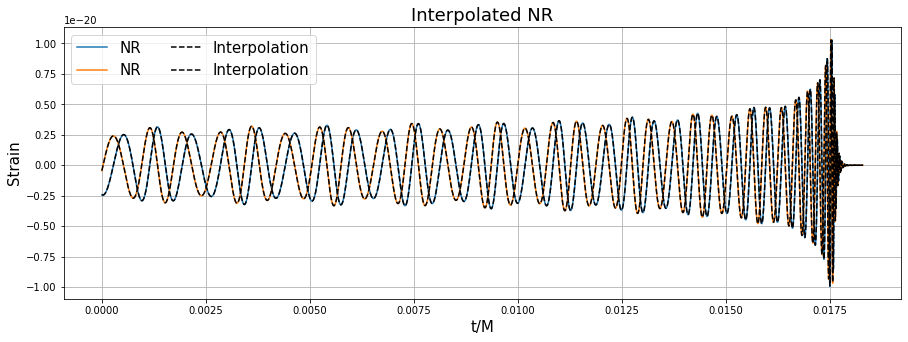

In [65]:
delta_t_NR=np.max(abs(np.diff(tVec_SI)))   
print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

plt.figure(figsize=(15,5))
plt.plot(tVec_SI,hpVec_SI,label='NR') 
plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(hpVec_NR.sample_times,hpVec_NR,'k--',label='Interpolation')
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')
plt.plot(tVec_NR,hc_NR_int,'k--',label='Interpolation')
plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15},ncol=2)
print(len(t),len(hpVec_NR),tVec[-1])

In [66]:
phiC=phase_NR[mergIdx_NR]         
#tC_NR=hpVec_NR.sample_times[mergIdx_NR]
#phiC=phase_NR[len(hpVec_NR)]         
tC_NR=max(hpVec_NR.sample_times)
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
conv=M*MTSUN_SI               #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(i):
    return(i**(3/2)/(M*MTSUN_SI*math.pi))
 
f_low=freq(xlow)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta) # this is using Moore evolution equation
#not using this eccentricity since we have used EccentricTD evolution to generate the initial eccentricity(e0) values

print(e) 
print(f_low)

0.14989892087434276
616.9065279526923


In [67]:
print(tC_NR)

0.018287321409781215


### Generating EccentricTD

In [68]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=d)

25454


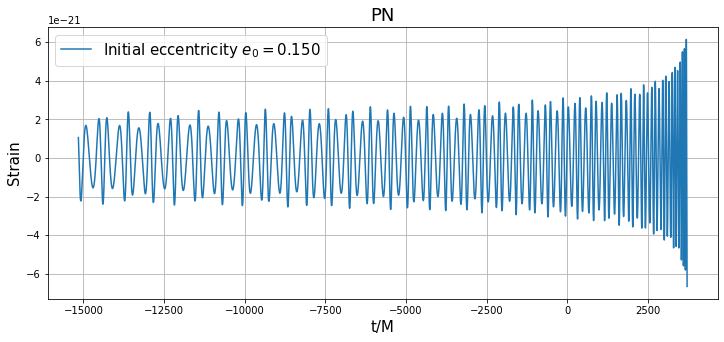

In [69]:
plt.figure(figsize=(12,5))
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times#-hpVec_PN.sample_times[-1]
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(hpVec_PN))

In [70]:
print(tVec_PN_shifted[-1])

0.018283670670144827


### obtaining EccentricTD phase

In [71]:
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

In [72]:
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))

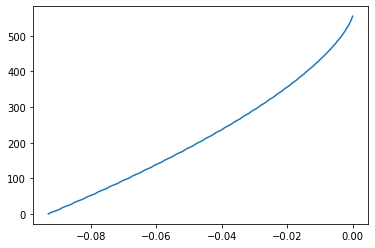

In [73]:
plt.plot(hpVec_PN.sample_times,phase_EccTD)

In [74]:
tC_NR=tC_NR/conv
tC_NR

3712.7915399588064

### Obtaining parameters for generating Ebersold+ amplitudes

In [75]:
tVec_PN=tVec_PN_GM
tC_NR=tC_NR

xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
#input initial params
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
#e0=(eref*(xi_ref/xi0)**(19/18))*(epsilon(xi0, eta)/epsilon(xi_ref, eta))
l0=mean_anomaly(xi_ref, xi0, lref, eta)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

In [76]:
print(tC_NR-tVec_PN)

[1.88671183e+04 1.88663771e+04 1.88656359e+04 ... 2.22364124e+00
 1.48241714e+00 7.41193034e-01]


In [81]:
xiVec=(np.pi*M*fVec)
#print('xiVec:', xiVec)
xVec=xiVec**(2/3)
print('xVec:', xVec)
vVec=xiVec**(1/3)

xVec: [0.04485664 0.0448571  0.04485755 ...        nan        nan        nan]


/home/croyt/pycbc/lib/python3.8/site-packages/pycbc/types/array.py:417: RuntimeWarning: invalid value encountered in power
  return self._data ** other


In [82]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)
print(maxPNidx)

25391


In [83]:
len(xVec), len(phase_EccTD)

(25391, 25454)

### Ebersold+ amplitudes

In [84]:
j=0
omega=[]
hlm_real=[]
hlm_imag=[]
hlm_abs=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    #psi=phase_TT2(v, v0, phiC, eta)+W(xie, xi0, eta, e0, l)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    
    #change according to the hlm required, check GW_functions.ipynb for the function definitions and arguements
    h=amplitude_22(xi,x,nu,e) 
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm0 = hlm *M0/d0
    hlm_real.append(hlm0.real)
    hlm_imag.append(hlm0.imag)
    hlm_abs.append(abs(hlm0))
print(len(hlm_real))

100%|████████████████████████████████████████████████████████| 25391/25391 [00:24<00:00, 1051.21it/s]

25391


In [85]:
mp, j

(2, 25391)

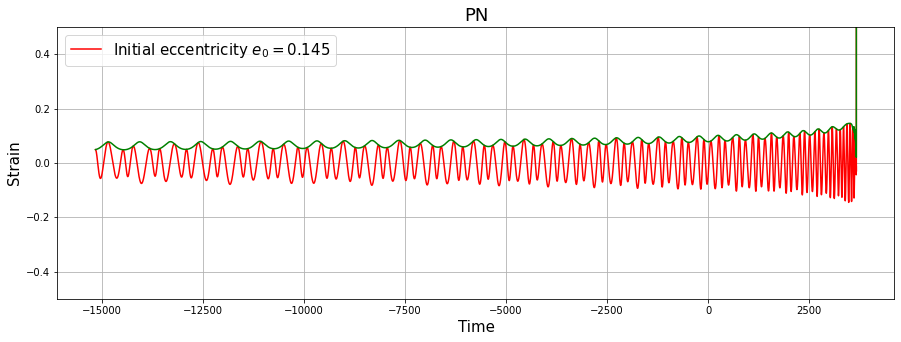

In [20]:
plt.figure(figsize=(15,5))
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real[:],'r',label='Initial eccentricity $e_0=%1.3f$' %e0)
plt.plot(tVec_PN_GM[:maxPNidx],hlm_abs[:],'g')
plt.title("PN", fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("Time", fontsize=15)
#plt.xlim(xmin=-500)
#plt.xlim(xmax=2500)
plt.ylim(-0.5e0,0.5e0)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig("4.png",dpi=300)

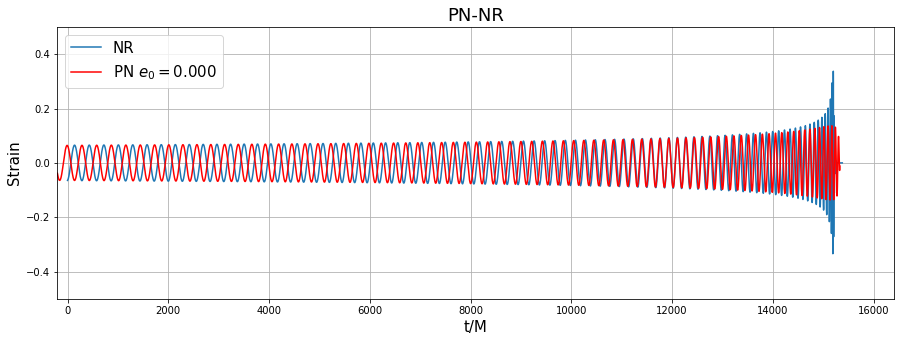

In [890]:
plt.figure(figsize=(15,5))
plt.plot(tVec_NR_GM, hpVec_NR/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), label='NR')
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real,'r',label='PN $e_0=%1.3f$' %e0)
#plt.plot(tVec_PN_GM[:maxPNidx],hlm_imag,'r',label='PN $e_0=%1.3f$' %e0)
plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=-200)
#plt.xlim(xmax=6700)
plt.title("PN-NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

### Hybridization routine

In [891]:
t1Idx_NR=np.where(tVec_NR_GM>=1000.0)[0][0]
t1Idx_PN=np.where(tVec_PN_GM>=1000.0)[0][0]

t2Idx_NR=np.where(tVec_NR_GM>=2000.0)[0][0]
t2Idx_PN=np.where(tVec_PN_GM>=2000.0)[0][0]

In [892]:
print(tVec_NR_GM[t1Idx_NR],tVec_PN_GM[t1Idx_PN])

1000.9262695096339 1000.83132327724


In [893]:
stretch=abs(tVec_NR_GM[t1Idx_NR]-tVec_NR_GM[t2Idx_NR])
print('NR matching window in t/M:',stretch)
print('NR matching indices:',t1Idx_NR,'\t',t2Idx_NR)

stretch=abs(tVec_PN_GM[t1Idx_PN]-tVec_PN_GM[t2Idx_PN])
print('\nPN matching window in t/M:',stretch)
print('PN matching indices:',t1Idx_PN,'\t',t2Idx_PN)

NR matching window in t/M: 999.4735463318258
NR matching indices: 689 	 1377

PN matching window in t/M: 999.3787730147376
PN matching indices: 4353 	 5041


In [894]:
print(t2Idx_NR - t1Idx_NR,t2Idx_PN-t1Idx_PN)

688 688


In [895]:
hpVec_NR_GM=hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)
hcVec_NR_GM=hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)

In [896]:
if (t2Idx_NR - t1Idx_NR)<(t2Idx_PN-t1Idx_PN):
    t2Idx_NR = t2Idx_NR+1

In [897]:
hpVec_NR_crop=hpVec_NR_GM[t1Idx_NR:t2Idx_NR]
hcVec_NR_crop=hcVec_NR_GM[t1Idx_NR:t2Idx_NR]
tVec_NR_crop=tVec_NR_GM[t1Idx_NR:t2Idx_NR]

def PN_crop(pnshiftIdx):
    hpVec_PN_crop=np.array(hlm_real[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    #hpVec_PN_crop=np.array(hlm_imag[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    tVec_PN_crop=tVec_PN_GM[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx]
    return(tVec_PN_crop, hpVec_PN_crop)

In [898]:
def deltaPNNR(param_Vec, h_NR_crop, h_PN_crop):
    #return(np.sum(abs(h_NR_crop-param_Vec[2]*h_PN_crop*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))
    return(np.sum(abs(h_NR_crop-h_PN_crop*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))

In [899]:
timeshiftIdxVec=np.arange(-500,500,1)

param_Vec_initial=[np.pi/2,0]
deltaVec=[]
paramVecmin=[]

for timeshiftIdx in timeshiftIdxVec:
    tVec_PN_crop, hpVec_PN_crop=PN_crop(timeshiftIdx)
    param_Vec_minimized = scipy.optimize.fmin(func=deltaPNNR, x0=param_Vec_initial, args=(hpVec_NR_crop,hpVec_PN_crop))
    deltaVec.append(deltaPNNR(param_Vec_minimized,hpVec_NR_crop,hpVec_PN_crop))
    paramVecmin.append(param_Vec_minimized)

Optimization terminated successfully.
         Current function value: 9.719931
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 8.826691
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 7.942121
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 7.090133
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 6.317513
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 5.648937
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 5.087278
         Iterations: 29
         Function evaluations: 54
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 13.894960
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 13.005129
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 12.111599
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 11.215386
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 10.316390
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 9.415234
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 8.513381
         Iterations: 28
         Function evaluations: 53
Optimization terminated succe

Optimization terminated successfully.
         Current function value: 16.845482
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 15.963863
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 15.078611
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 14.188914
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 13.295676
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 12.398864
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 11.499293
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 21.190440
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 20.329112
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 19.461992
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 18.589835
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 17.713466
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 16.831468
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 15.946426
         Iterations: 28
         Function evaluations: 53
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 23.458154
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 22.606215
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 21.749312
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 20.886070
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 20.018173
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 19.144555
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 18.266429
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 26.238430
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 25.403219
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 24.560475
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 23.712401
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 22.857407
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 21.997359
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 21.131009
         Iterations: 28
         Function evaluations: 53
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 27.033276
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 26.198401
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 25.357659
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 24.509670
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 23.656284
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 22.796088
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 21.930969
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 29.175529
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 28.355156
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 27.525698
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 26.691054
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 25.847943
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 24.999968
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 24.144091
         Iterations: 28
         Function evaluations: 53
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 30.190135
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 29.372568
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 28.548148
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 27.715935
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 26.877248
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 26.031317
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 25.179294
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 28.435512
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 27.598328
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 26.752872
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 25.902063
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 25.043498
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 24.180018
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 23.309322
         Iterations: 28
         Function evaluations: 53
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 24.586335
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 23.714449
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 22.837030
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 21.953936
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 21.065675
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 20.172381
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 19.274301
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

In [901]:
minIdx=np.argmin(deltaVec)
phaseshift_min=paramVecmin[minIdx][0]
angularshift_min=paramVecmin[minIdx][1]
#ampshift_min=paramVecmin[minIdx][2]
timeshiftIdx_min=timeshiftIdxVec[minIdx]
minIdx, timeshiftIdx_min, phaseshift_min, angularshift_min #ampshift_min

(603, 103, -0.000918066529154834, 0.000926101386547089)

In [902]:
tau_new=tVec_PN_GM-(timeshiftIdx_min*delta_t_common/conv)
#tau_newc=tVec_PN_GM-(timeshiftIdx_minc*delta_t_common/conv)
hpVec_PN_phaseshifted=np.array(hlm_real)*(np.e)**(1j*phaseshift_min+angularshift_min)
hcVec_PN_phaseshifted=np.array(hlm_imag)*(np.e)**(1j*phaseshift_min+angularshift_min)

/home/croyt/pycbc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/croyt/pycbc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


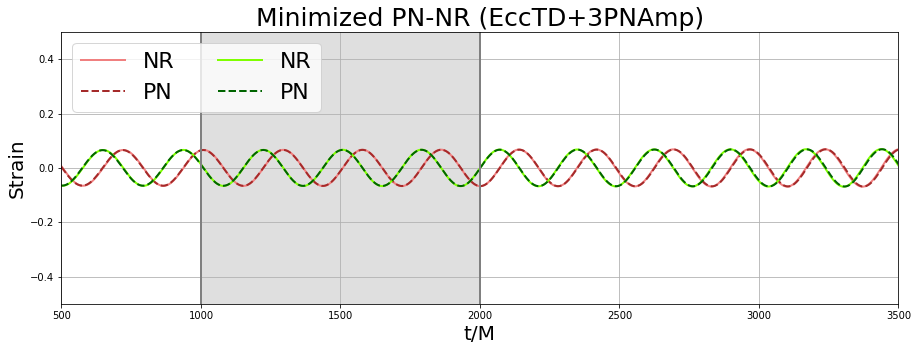

In [903]:
plt.figure(figsize=(15,5))
plt.plot(tVec_NR_GM,hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='lightcoral',linewidth=2,label='NR')
plt.plot(tau_new[:maxPNidx],hpVec_PN_phaseshifted[:],color='brown',linestyle='--',linewidth=2,label='PN')
plt.plot(tVec_NR_GM,hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='chartreuse',linewidth=2,label='NR')
plt.plot(tau_new[:maxPNidx],hcVec_PN_phaseshifted[:],color='darkgreen',linestyle='--',linewidth=2,label='PN')
plt.title("Minimized PN-NR (EccTD+3PNAmp)", fontsize=25)
plt.ylabel("Strain", fontsize=20)
plt.xlabel("t/M", fontsize=20)

plt.axvline(x=tVec_NR_GM[int(t1Idx_NR)],linewidth=2, color='gray')
plt.axvline(x=tVec_NR_GM[int(t2Idx_NR)],linewidth=2, color='gray')
plt.axvspan(tVec_NR_GM[int(t1Idx_NR)], tVec_NR_GM[int(t2Idx_NR)],  alpha=0.5, color='silver')

plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=500)
plt.xlim(xmax=3500)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.legend(loc=2,prop={'size': 22},ncol=2)
plt.grid()
#plt.savefig('0184TT2.jpg',dpi=600)

In [905]:
hyb_time=[]
hyb_hp=[]
hyb_hc=[]

T1_PN=t1Idx_PN
T2_PN=t2Idx_PN

T1_NR=t1Idx_NR
T2_NR=t2Idx_NR

In [906]:
for i in tau_new[:T1_PN+timeshiftIdx_min]:
    hyb_time.append(i)

for i in hpVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hp.append(i)
    
for i in hcVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hc.append(i)

In [907]:
for i,j in tqdm(zip(range(T1_NR,T2_NR), range((T1_PN+timeshiftIdx_min),(T2_PN+timeshiftIdx_min)))):
    tau=float((tVec_NR_GM[i]-tVec_NR_GM[int(T1_NR)])/(tVec_NR_GM[int(T2_NR)]-tVec_NR_GM[int(T1_NR)]))
    hpval=tau*hp_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hpVec_PN_phaseshifted[j])
    hcval=tau*hc_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hcVec_PN_phaseshifted[j])
    
    hyb_hp.append(hpval)
    hyb_hc.append(hcval)
    hyb_time.append(tVec_NR_GM[i])

688it [00:00, 33326.57it/s]


In [908]:
for i in tVec_NR_GM[T2_NR:]:
    hyb_time.append(i)
for i in hp_NR_int[T2_NR:]:
    hyb_hp.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
for i in hc_NR_int[T2_NR:]:
    hyb_hc.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

(-1000.0, 16421.048405013215)

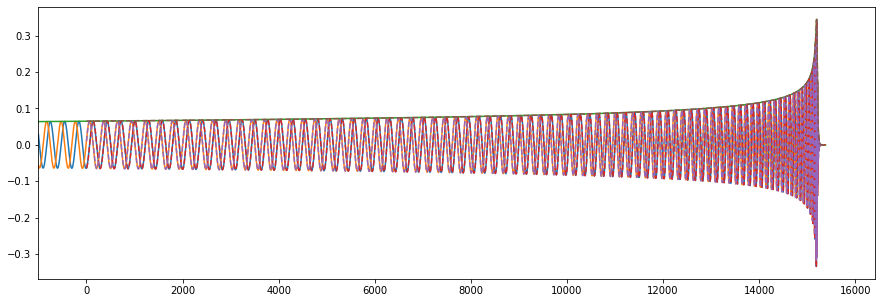

In [909]:
plt.figure(figsize=(15,5))
plt.plot(hyb_time,np.real(hyb_hp))
plt.plot(hyb_time,np.real(hyb_hc))
plt.plot(hyb_time,np.abs(np.real(hyb_hp)+1j*np.real(hyb_hc)))
plt.plot(tVec_NR_GM,hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,abs(hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+1j*hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))),'--')
#plt.plot(hpVec_PN.sample_times/(MTSUN_SI)+3000,hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.xlim(xmin=-1000)

### Saving hybrids to an HDF file

In [910]:
print(len(hyb_hp),len(hyb_hc),len(hyb_time))

14354 14354 14354


In [859]:
DataArray = np.transpose([hyb_time, np.real(hyb_hp), np.real(hyb_hc)])

In [860]:
hf = h5py.File(sims+'_EccTD_Ebersold_HM.h5', 'a') ## change name of file to be created as required

In [861]:
#hf.create_dataset('l2_m2', data=DataArray)
hf.create_dataset(mode, data=DataArray)

<HDF5 dataset "l5_m4": shape (14499, 3), type "<f8">

In [862]:
hf.close()

### Checking the HDF file

In [863]:
hf = h5py.File(sims+'_EccTD_Ebersold_HM.h5','r')

In [864]:
print(hf.keys())

<KeysViewHDF5 ['l2_m1', 'l2_m2', 'l3_m2', 'l3_m3', 'l4_m3', 'l4_m4', 'l5_m4', 'l5_m5']>


In [865]:
testd = hf.get(mode)

In [866]:
print(len(testd[:,0]),testd[0,0])

14499 -5682.514221258819


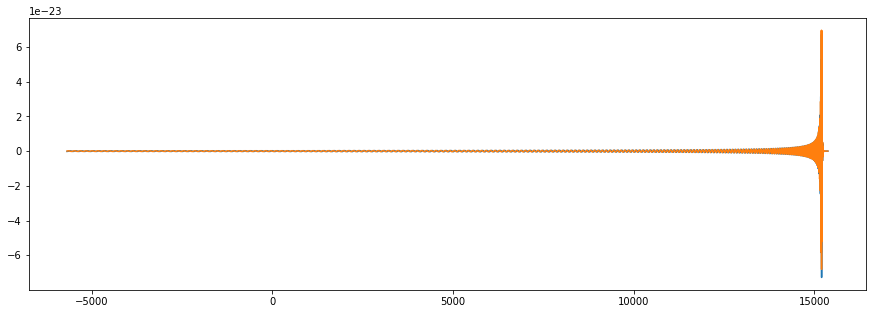

In [867]:
plt.figure(figsize=(15,5))
plt.plot(testd[:,0],testd[:,1]*G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(testd[:,0],testd[:,2]*G_SI*M_SI/D_SI/C_SI/C_SI)
#plt.xlim(xmin=-1000)

In [868]:
hf.close()